<a href="https://colab.research.google.com/github/kally1218/pycharmproject/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
#让jupter直接在界面内部显示图像,不要新建窗口
import random
import torch
!pip install d2l==1.0.3
from d2l import torch as d2l #d2l的包是沐神自己写的

In [3]:
#构造人造数据的样本,好处是知道真是的w和b的参数
#有随机噪声
def synthetic_data(w, b, num_examples):
  #生成一个函数y = Xw + b + 噪声
  X = torch.normal(0, 1, (num_examples, len(w))) #X是均值为0方差是1的随机数,有n个样本,列数为w的长度,函数写法:torch.normal(mean=0.0, std=1.0, size)
  y = torch.matmul(X, w) + b #matmul是matrix的multiple,矩阵乘法,b是bias
  y += torch.normal(0, 0.01, y.shape) #y加入一个随机噪音,形状和y一样
  return X, y.reshape((-1, 1)) #函数没有return会默认返回None的

true_w = torch.tensor([2, -3.4]) #设定真实w
true_b = 4.2 #设定真实b
features, labels = synthetic_data(true_w, true_b, 1000) #用上面这个定义的函数生成features and labels

In [30]:
print('features:', features[0], '\nlabels: ', labels[0])
#features中,每一行都有两列, labels中,每一行都有一个scalar(标量)
#不懂为什么label是y: 那是因为在def定义的函数里,看return怎么写的, 那就在设定的时候,按照顺序命名,而且在机器学习中, features是X, label就是y

features: tensor([ 0.2283, -0.6871]) 
labels:  tensor([6.9938])


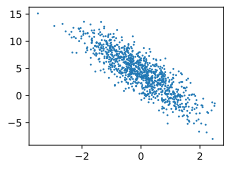

In [45]:
d2l.set_figsize()
#画第一列特征,detach在某些版本里需要先抽取数值,才能转到numpy里面去;label
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

定义一个函数,命名为data_iter,用于把下面的三个参数作为input输入:batch_size, features, labels, 结果生成的size是batch_size的小batch的样本, 简单来说就是如果我要在1000个样本带标号的数据里分批随机抽取的话,就要这么定义

In [46]:
def data_iter(batch_size, features, labels):
  #设置样本的长度是特征的长度
  num_examples = len(features)
  #indices是索引index的复数,生成一个列表,是数学里的下标
  indices = list(range(num_examples))
  #设定随机读取indices的列表,无特定顺序,完全打乱
  random.shuffle(indices)
  #每一次挑batch_size的大小的
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i:min(i + batch_size, num_examples)] #索引值的list会设定成从i开始到规定的批量大小的最后索引值, 为了防止出现最后一个batch的特征值的量会和之前的size不一样,用了min函数取两者最小值,比如 i + batch_size > num_examples（比如数据只剩3条，但你 batch_size 是5），那就会越界！
    )
    #yield函数用于不断返回你要的features和labels(python里面的函数)
    yield features[batch_indices], labels[batch_indices]

#设定batch_size
batch_size = 10


for X, y in data_iter(batch_size, features, labels):
  print(X, '\n',y)
  #break用于跳出for循环,这边就是只展示第一个batch_size的features和lables
  break

tensor([[ 0.7312, -0.0089],
        [-1.7120,  2.2258],
        [-1.0399,  0.5099],
        [ 0.1851, -0.4403],
        [ 1.5318, -1.1066],
        [ 0.5867, -0.0631],
        [ 0.1938, -1.2809],
        [-0.7537, -0.5596],
        [-0.6276,  0.3871],
        [ 0.7502, -1.3284]]) 
 tensor([[ 5.6982],
        [-6.8009],
        [ 0.3920],
        [ 6.0658],
        [11.0352],
        [ 5.5966],
        [ 8.9515],
        [ 4.5963],
        [ 1.6461],
        [10.2177]])


接下来, 定义和初始化模型的参数w啊b啊之类的

In [68]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) #True表示要让pytorch计算梯度
#b初始值设定0
b = torch.zeros(1, requires_grad=True) #requires_grad表示要让pytorch计算梯度


然后就要定义模型了

In [61]:
def linreg(X, y, n):
  """线性回归模型"""
  return torch.matmul(X, w) + b

用均方误差定义损失函数

In [62]:
def squared_loss(y_hat, y):
  """均方误差当损失"""
  #为了防止向量的形状不同,y的shape和y_hat的shape最好事前统一)
  #返回均方误差公式,BUT!此处没有做均值
  #为什么除2?? 因为要用来求导算梯度, 那么平方求导多了一个2, 除2用于抵消导数的2了,简化计算
  return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法,名字为sgd,包含了paras, learning rate(lr), batch_size_

In [63]:
def sgd(params, lr, batch_size):
  """这边是小批量的随机样本的梯度下降算法设计"""
  #先不更新梯度
  """默认情况下，PyTorch 会自动记录所有操作以便后向传播（用来训练神经网络），但是：
  在 预测/验证阶段，你通常不需要计算梯度 —— 这样做只会浪费显存和计算资源。
  所以用 with torch.no_grad() 来告诉 PyTorch：我现在只是用模型来做预测，
  不需要你记录梯度，也不需要你帮我反向传播。
  #with的用法是自动处理资源的“进入”和“退出”过程。"""
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size #BUT这边除batch_size是做均值了, 放在上面代码块和下面都一样的
      #手动设置梯度为0
      param.grad.zero_()

开始训练!!!

In [69]:
#设定learning rate, 可以自行调整
lr = 10
#设定epoch, 就是每个数据扫几遍
num_epochs = 10
#定义一个模型名字,方便后续直接更换其他模型
net = linreg
#定义loss function
loss = squared_loss

for epoch in range(num_epochs):
  #for循环就是每次拿出一个batch_size的X和y(也就是features和labels)
  for X, y in data_iter(batch_size, features, labels):
    #把X,w,b放入我的net, 和y做loss损失计算
    l = loss(net(X, w, b), y)
    #print(l.shape)
    #对l求和,并算梯度用backward()
    #WHY?? - sum啊backwrad啊后面要加括号呢
    #因为- 在Python 里，调用函数必须加括号，哪怕你不传参数。
    l.sum().backward()
    #用sgd对w和b做更新
    sgd([w, b], lr, batch_size)#由于这边的例子batch size可以整除才会这么做
  with torch.no_grad(): #注意这边的identation是在第一层下面的不是第二层
    train_l = loss(net(features, w, b), labels)
    #Python 3.6+ 引入的一种字符串格式化方式，可以在字符串中直接插入变量，非常直观。
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss nan
epoch 2, loss nan
epoch 3, loss nan
epoch 4, loss nan
epoch 5, loss nan
epoch 6, loss nan
epoch 7, loss nan
epoch 8, loss nan
epoch 9, loss nan
epoch 10, loss nan


由于这个例子我们自定义了真实的w和b, 可以做减法计算模型在梯度下降后得到的参数是否和实际的w和b接近

In [67]:
print(f'w估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b估计误差: {true_b - b}')

w估计误差: tensor([ 0.5711, -1.0211], grad_fn=<SubBackward0>)
b估计误差: tensor([1.1088], grad_fn=<RsubBackward1>)
